# Decision-Focused Learning 

### Library import

In [4]:
import os, random, numpy as np, pandas as pd, torch, cvxpy as cp, matplotlib.pyplot as plt
from tqdm import tqdm
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [2]:
import yfinance as yf

In [1]:
import sys, subprocess
def _pip_install(pkg): 
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

try:
    import yfinance
except ImportError:
    _pip_install("yfinance")

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/16/bf/7c0c89ff8ba53592b9cb5157f70e90d8bbb04d60094fc4f10035e158b981/yfinance-0.2.66-py2.py3-none-any.whl.metadata
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/ba/d0/d482c39cee2ab2978a892558cf130681d4574ea208e162da8958b31e9250/frozendict-2.4.6-py312-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting r


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


### Load and prepare financial data  
Download stock price data from Yahoo Finance and compute returns, mean vector (μ), and covariance matrix (Σ).

In [9]:
def get_portfolio_data(tickers, start="2018-01-01", end="2023-12-31", freq="1d", visualize=True):
    print(f"Downloading {len(tickers)} assets from {start} to {end} ...")
    data = yf.download(
        tickers,
        start=start,
        end=end,
        interval=freq,
        group_by="column",
        auto_adjust=True,
        progress=False,
        threads=True,
    )

    if data.empty:
        raise RuntimeError("Downloaded data is empty. Check tickers, dates or internet connection.")

    if isinstance(data.columns, pd.MultiIndex):
        lvl0 = data.columns.get_level_values(0)
        if "Close" in lvl0:
            prices = data.xs("Close", axis=1, level=0)
        elif "Adj Close" in lvl0:
            prices = data.xs("Adj Close", axis=1, level=0)
        else:
            raise KeyError(f"Expected 'Close' or 'Adj Close' in columns level-0. Found: {sorted(set(lvl0))}")
    else:
        cols = data.columns
        if "Close" in cols:
            prices = data["Close"].to_frame() if not isinstance(tickers, (list, tuple)) else data["Close"]
        elif "Adj Close" in cols:
            prices = data["Adj Close"].to_frame() if not isinstance(tickers, (list, tuple)) else data["Adj Close"]
        else:
            raise KeyError(f"Expected 'Close' or 'Adj Close' in columns. Found: {list(cols)}")

    prices = prices.dropna(axis=0, how="any")
    if prices.empty:
        raise RuntimeError("Prices are empty after dropna(). Try a wider date range or different tickers.")

    returns = np.log(prices / prices.shift(1)).dropna()
    mu = returns.mean().values
    Sigma = returns.cov().values

    prices.to_csv("data/raw/prices.csv")
    returns.to_csv("data/processed/returns.csv")
    pd.DataFrame(mu, index=returns.columns, columns=["mu"]).to_csv("data/processed/mu.csv")
    pd.DataFrame(Sigma, index=returns.columns, columns=returns.columns).to_csv("data/processed/Sigma.csv")

    if visualize:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        prices.plot(ax=axes[0], legend=False)
        axes[0].set_title("Adjusted Close (auto_adjust=True)"); axes[0].set_xlabel("Date"); axes[0].set_ylabel("Price")
        corr = returns.corr()
        im = axes[1].imshow(corr, vmin=-1, vmax=1)
        axes[1].set_xticks(range(len(corr.columns))); axes[1].set_xticklabels(corr.columns, rotation=45, ha="right")
        axes[1].set_yticks(range(len(corr.index)));  axes[1].set_yticklabels(corr.index)
        axes[1].set_title("Return Correlation Heatmap")
        fig.colorbar(im, ax=axes[1])
        plt.tight_layout(); plt.show()

    return prices, returns, mu, Sigma

### Run data fetching  
Select a list of assets and retrieve prices, returns, and covariance matrix.

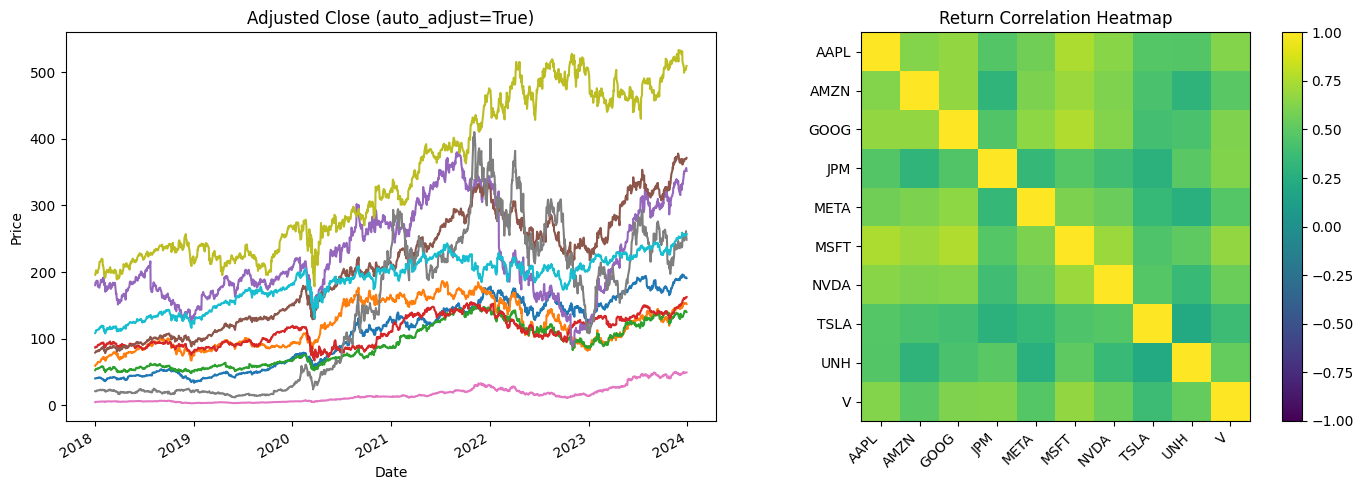


μ (mean returns) first 5: [0.00103 0.00062 0.00065 0.00042 0.00044]
Σ shape: (10, 10)


In [10]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "META", "NVDA", "JPM", "TSLA", "UNH", "V"]

prices, returns, mu, Sigma = get_portfolio_data(
    tickers=tickers,
    start="2018-01-01",
    end="2023-12-31",
    freq="1d",
    visualize=True
)

print("\nμ (mean returns) first 5:", np.round(mu[:5], 5))
print("Σ shape:", Sigma.shape)

### Portfolio Optimization Solver  
Define the quadratic programming (QP) problem for portfolio optimization.  
This solver will be used both for the Predict-Then-Optimize baseline and for DFL methods.